# Offline Signature Verification — **Siamese Vision Mamba** (Contrastive + Explainability)

**Objectives**
- **Adopt** a pre-trained **Vision Mamba / MambaOut Tiny** backbone and integrate it into a **Siamese** architecture for offline signature verification.
- **Fine‑tune** the model on offline signature datasets to adapt learned representations for signature‑specific features.
- **Train** with **contrastive learning** (e.g., classic Contrastive Loss) to enhance discriminative power.
- **Explain** predictions using **visual explainability** (e.g., saliency/Grad‑CAM‑style maps) to highlight signature regions that drive decisions.
- **Evaluate** with **Accuracy**, **Equal Error Rate (EER)**, and other relevant metrics on benchmark offline signature datasets.

**CONFIG**

In [1]:
# CONFIGURATION
import os, random, numpy as np, torch
from pathlib import Path

# Try common locations; pick the first that exists
candidates = [
    Path(r"C:\Users\megel\Documents\signature-mamba\cedar_dataset"),
    Path("cedar_dataset"),
    Path("./data/CEDAR"),
    Path("data/cedar_dataset"),
]
ROOT_PATH = next((c for c in candidates if c.exists()), None)
if ROOT_PATH is None:
    raise FileNotFoundError("Put the dataset under 'cedar_dataset' (with full_org/ and full_forg/).")
ROOT = str(ROOT_PATH.resolve())

# Request a Vision Mamba; we'll pick the closest available later
REQUESTED_BACKBONE = "mambaout_tiny.in1k"

# Image + training hyperparams
SIZE   = 224
BATCH  = 16
EPOCHS = 6
LR     = 2e-4
MARGIN = 0.7
SEED   = 123

# --- knobs that usually help metrics ---
THRESH_MODE = "youden"          # "maxacc" | "youden" | "eer"
FREEZE_EPOCHS = 2               # freeze backbone first N epochs, then unfreeze
UNFREEZE_BACKBONE_LR_MULT = 0.25
USE_STRONG_AUG = True           # stronger but safe aug for signatures
RESAMPLE_TRAIN_EVERY_EPOCH = True  # new pair combos each epoch

# Keep runtime practical (pairs can explode)
CAP_TOTAL_PAIRS       = 140_000    # total pairs BEFORE 70/20/10
MAX_STEPS_PER_EPOCH   = 8750       # limit batches per epoch (None = full)
WRITER_DISJOINT_SPLIT = True       # split by signer (recommended)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.set_float32_matmul_precision("high")
    torch.backends.cudnn.benchmark = True

print("DEVICE:", DEVICE)
print("ROOT:", ROOT)
print("Subfolders:", [p.name for p in Path(ROOT).iterdir() if p.is_dir()])


KeyboardInterrupt: 

**DATASET & LOADERS (+ caching, writer-disjoint split)**

In [ ]:
# DATASET & LOADERS (with caching, optional writer-disjoint)
from typing import List
from collections import defaultdict
from PIL import Image
import re, hashlib
import numpy as np
import torch
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from pathlib import Path

# Jupyter/VS Code friendly progress bars
try:
    from tqdm.notebook import tqdm
except Exception:
    from tqdm.auto import tqdm

# Optional OpenCV (faster binarize+crop). Fallback if missing.
try:
    import cv2
    HAVE_CV2 = True
except Exception:
    HAVE_CV2 = False

class PairSample:
    def __init__(self, img1_path: Path, img2_path: Path, label: int):
        self.img1_path = img1_path
        self.img2_path = img2_path
        self.label = label  # 1 = same (Authentic), 0 = different (Forged)

def signer_key(name: str) -> str:
    parts = re.sub(r"[-_]", ".", name).split(".")
    for t in parts:
        if t.isdigit(): return t
    return "unknown"

def _gather_images(dirpath: Path) -> List[Path]:
    exts = (".png",".jpg",".jpeg",".bmp",".tif",".tiff")
    return [p for p in dirpath.rglob("*") if p.suffix.lower() in exts]

def _first_existing(parent: Path, names: List[str]) -> Path | None:
    parent = parent.resolve()
    for n in names:
        p = parent / n
        if p.exists() and p.is_dir():
            return p
    return None

# --- preprocessing (binarize + tight crop) with disk cache ---
CACHE_DIR = Path("cache_preproc"); CACHE_DIR.mkdir(exist_ok=True)

def _cache_key(p: Path):
    s = f"{str(p.resolve())}|{p.stat().st_mtime_ns}"
    return hashlib.md5(s.encode()).hexdigest() + ".pt"

def binarize_and_crop(pil_img: Image.Image) -> Image.Image:
    if not HAVE_CV2:
        return pil_img.convert("L").convert("RGB")
    img = np.array(pil_img.convert("L"))
    _, thr = cv2.threshold(255 - img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    cnts, _ = cv2.findContours(thr, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(cnts) == 0:
        return pil_img.convert("RGB")
    c = max(cnts, key=cv2.contourArea)
    x,y,w,h = cv2.boundingRect(c)
    pad = int(0.05 * max(w,h))
    x0 = max(0, x - pad); y0 = max(0, y - pad)
    x1 = min(img.shape[1], x + w + pad); y1 = min(img.shape[0], y + h + pad)
    crop = img[y0:y1, x0:x1]
    crop = cv2.cvtColor(crop, cv2.COLOR_GRAY2RGB)
    return Image.fromarray(crop)

def load_preprocessed_as_pil_rgb(p: Path) -> Image.Image:
    key = _cache_key(p); f = CACHE_DIR / key
    if f.exists():
        ten = torch.load(f)  # 1xHxW float [0..1]
        arr = (ten.squeeze(0).numpy() * 255).astype(np.uint8)
        return Image.fromarray(arr).convert("RGB")
    pil = binarize_and_crop(Image.open(p))
    arr = np.asarray(pil.convert("L"), dtype=np.uint8).copy()
    ten = torch.from_numpy(arr).unsqueeze(0).to(torch.float32) / 255.0
    torch.save(ten, f)
    return pil

def scan_dataset(root: str):
    root = Path(root).resolve()
    ORG_CANDIDATES  = ["ful_org","full_org","original","originals","genuine","genuines"]
    FORG_CANDIDATES = ["full_forg","forg","forgery","forgeries","forged","impostor","impostors"]
    org_dir = _first_existing(root, ORG_CANDIDATES)
    forg_dir = _first_existing(root, FORG_CANDIDATES)
    if org_dir is None or forg_dir is None:
        raise FileNotFoundError(
            f"Could not find originals or forgeries dirs under {root}. "
            f"Tried originals={ORG_CANDIDATES}, forgeries={FORG_CANDIDATES}"
        )
    org_by_signer = defaultdict(list)
    for p in _gather_images(org_dir):
        org_by_signer[signer_key(p.name)].append(p)
    forg_by_signer = defaultdict(list)
    for p in _gather_images(forg_dir):
        forg_by_signer[signer_key(p.name)].append(p)
    return org_by_signer, forg_by_signer

def split_signers(all_signers: List[str], ratios=(0.7,0.2,0.1), seed=123):
    rng = random.Random(seed)
    ss = list(all_signers); rng.shuffle(ss)
    n = len(ss); n_train = int(ratios[0]*n); n_val = int(ratios[1]*n)
    trainS = set(ss[:n_train]); valS = set(ss[n_train:n_train+n_val]); testS = set(ss[n_train+n_val:])
    return trainS, valS, testS

def build_pairs_for_signers(org_by_signer, forg_by_signer, signer_subset, rng):
    pos_pairs, neg_pairs = [], []
    # positives: two originals of same signer
    for s in signer_subset:
        imgs = org_by_signer.get(s, [])
        if len(imgs) < 2: 
            continue
        for i in range(len(imgs)):
            for j in range(i+1, len(imgs)):
                pos_pairs.append(PairSample(imgs[i], imgs[j], 1))
    # skilled forgeries: original vs forgery for same signer
    for s in signer_subset:
        orgs = org_by_signer.get(s, [])
        forgs = forg_by_signer.get(s, [])
        for o in orgs:
            for f in forgs:
                neg_pairs.append(PairSample(o, f, 0))
    # impostors: originals from different signers (extra negatives)
    signers = [s for s in signer_subset if len(org_by_signer.get(s,[]))>0]
    for _ in range(max(1, (len(pos_pairs)+len(neg_pairs))//4)):
        if len(signers) < 2: break
        s1, s2 = rng.choice(signers), rng.choice(signers)
        if s1 == s2: continue
        o1 = rng.choice(org_by_signer[s1])
        o2 = rng.choice(org_by_signer[s2])
        neg_pairs.append(PairSample(o1, o2, 0))
    # balance pos/neg
    n_min = min(len(pos_pairs), len(neg_pairs))
    if n_min == 0:
        raise RuntimeError("No positive or negative pairs found; check dataset completeness.")
    rng.shuffle(pos_pairs); rng.shuffle(neg_pairs)
    pos_pairs = pos_pairs[:n_min]; neg_pairs = neg_pairs[:n_min]
    all_pairs = pos_pairs + neg_pairs
    rng.shuffle(all_pairs)
    return all_pairs

class PairsDataset(Dataset):
    def __init__(self, pairs: List[PairSample], size: int, split: str):
        self.samples = pairs
        aug = []
        if split == "train":
            if USE_STRONG_AUG:
                aug = [
                    T.RandomApply([T.RandomRotation(degrees=3)], p=0.4),
                    T.RandomApply([T.RandomAffine(degrees=3, translate=(0.02,0.02),
                                                  scale=(0.98,1.02), shear=2)], p=0.5),
                    T.RandomApply([T.GaussianBlur(kernel_size=3)], p=0.3),
                ]
            else:
                aug = [
                    T.RandomApply([T.RandomRotation(degrees=3)], p=0.5),
                    T.RandomApply([T.GaussianBlur(kernel_size=3)], p=0.3),
                ]
        self.tf = T.Compose([
            T.Lambda(lambda im: binarize_and_crop(im)),
            *aug,
            T.Resize((size, size)),
            T.ToTensor(),
            T.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]),
        ])

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        s = self.samples[idx]
        im1 = load_preprocessed_as_pil_rgb(s.img1_path)
        im2 = load_preprocessed_as_pil_rgb(s.img2_path)
        x1 = self.tf(im1); x2 = self.tf(im2)
        y = torch.tensor([s.label], dtype=torch.float32)
        return x1, x2, y

def make_loaders(root: str, size: int, batch: int, seed: int, cap_total_pairs: int | None, writer_disjoint=True):
    rng = random.Random(seed)
    org_by_signer, forg_by_signer = scan_dataset(root)

    if writer_disjoint:
        signers = sorted(set(org_by_signer.keys()) | set(forg_by_signer.keys()))
        trainS, valS, testS = split_signers(signers, (0.7,0.2,0.1), seed)
        train_pairs = build_pairs_for_signers(org_by_signer, forg_by_signer, trainS, rng)
        val_pairs   = build_pairs_for_signers(org_by_signer, forg_by_signer, valS, rng)
        test_pairs  = build_pairs_for_signers(org_by_signer, forg_by_signer, testS, rng)
    else:
        all_pairs = build_pairs_for_signers(org_by_signer, forg_by_signer,
                                            set(org_by_signer.keys())|set(forg_by_signer.keys()), rng)
        n = len(all_pairs); n_train = int(0.7*n); n_val = int(0.2*n)
        train_pairs = all_pairs[:n_train]; val_pairs = all_pairs[n_train:n_train+n_val]; test_pairs = all_pairs[n_train+n_val:]

    # cap AFTER building each split
    if cap_total_pairs is not None:
        train_pairs = train_pairs[: int(0.7*cap_total_pairs)]
        val_pairs   = val_pairs[: int(0.2*cap_total_pairs)]
        test_pairs  = test_pairs[: max(1, cap_total_pairs - len(train_pairs) - len(val_pairs))]

    train_ds = PairsDataset(train_pairs, size, "train")
    val_ds   = PairsDataset(val_pairs,   size, "val")
    test_ds  = PairsDataset(test_pairs,  size, "test")

    g = torch.Generator().manual_seed(seed)
    train_loader = DataLoader(train_ds, batch_size=batch, shuffle=True,  num_workers=0, pin_memory=True, generator=g)
    val_loader   = DataLoader(val_ds,   batch_size=batch, shuffle=False, num_workers=0, pin_memory=True)
    test_loader  = DataLoader(test_ds,  batch_size=batch, shuffle=False, num_workers=0, pin_memory=True)

    print(f"Pairs -> train: {len(train_ds)} | val: {len(val_ds)} | test: {len(test_ds)}")
    return train_loader, val_loader, test_loader


**PARTITION SUMMARY + LEAKAGE CHECK**

In [ ]:
#PARTITION SUMMARY + LEAKAGE CHECK
def summarize_partitions(root: str, seed: int = SEED, ratios=(0.7,0.2,0.1), cap_total_pairs: int | None = CAP_TOTAL_PAIRS):
    rng = random.Random(seed)
    org_by_signer, forg_by_signer = scan_dataset(root)
    signers = sorted(set(org_by_signer.keys()) | set(forg_by_signer.keys()))
    n_total = len(signers)
    n_train_tgt = int(ratios[0]*n_total); n_val_tgt = int(ratios[1]*n_total); n_test_tgt = n_total - n_train_tgt - n_val_tgt

    trainS, valS, testS = split_signers(signers, ratios, seed)

    def count_imgs(subset):
        gen = sum(len(org_by_signer.get(s, []))  for s in subset)
        forg = sum(len(forg_by_signer.get(s, [])) for s in subset)
        return gen, forg

    g_tr, f_tr = count_imgs(trainS)
    g_va, f_va = count_imgs(valS)
    g_te, f_te = count_imgs(testS)

    train_pairs = build_pairs_for_signers(org_by_signer, forg_by_signer, trainS, rng)
    val_pairs   = build_pairs_for_signers(org_by_signer, forg_by_signer, valS, rng)
    test_pairs  = build_pairs_for_signers(org_by_signer, forg_by_signer, testS, rng)
    if cap_total_pairs is not None:
        train_pairs = train_pairs[: int(ratios[0]*cap_total_pairs)]
        val_pairs   = val_pairs[: int(ratios[1]*cap_total_pairs)]
        test_pairs  = test_pairs[: max(1, cap_total_pairs - len(train_pairs) - len(val_pairs))]

    print(f"Pairs -> train: {len(train_pairs):,} | val: {len(val_pairs):,} | test: {len(test_pairs):,}")
    print(f"Total writers: {n_total} | target≈ train {n_train_tgt}, val {n_val_tgt}, test {n_test_tgt}")
    print(f"Actual writers: train={len(trainS)}, val={len(valS)}, test={len(testS)}\n")

    print("--- Partition Summary ---")
    print(f"{'Partition':<10} {'Num Signers':>12} {'Genuine Sigs':>14} {'Forged Sigs':>13}")
    print(f"{'Train':<10} {len(trainS):>12} {g_tr:>14} {f_tr:>13}")
    print(f"{'Validation':<10} {len(valS):>12} {g_va:>14} {f_va:>13}")
    print(f"{'Test':<10} {len(testS):>12} {g_te:>14} {f_te:>13}\n")

    o_tv = trainS & valS; o_tt = trainS & testS; o_vt = valS & testS
    print("--- Leakage Check ---")
    print(f"Train-Val Overlap: {len(o_tv)} signers")
    print(f"Train-Test Overlap: {len(o_tt)} signers")
    print(f"Val-Test Overlap: {len(o_vt)} signers")
    if len(o_tv)==0 and len(o_tt)==0 and len(o_vt)==0:
        print("No data leakage detected.")
    else:
        print(" Potential leakage: investigate overlaps.")

# Run summary
summarize_partitions(ROOT, seed=SEED, ratios=(0.7,0.2,0.1), cap_total_pairs=CAP_TOTAL_PAIRS)


Pairs -> train: 20,976 | val: 6,072 | test: 3,312
Total writers: 55 | target≈ train 38, val 11, test 6
Actual writers: train=38, val=11, test=6

--- Partition Summary ---
Partition   Num Signers   Genuine Sigs   Forged Sigs
Train                38            912           912
Validation           11            264           264
Test                  6            144           144

--- Leakage Check ---
Train-Val Overlap: 0 signers
Train-Test Overlap: 0 signers
Val-Test Overlap: 0 signers
No data leakage detected.


**MODEL (Vision Mamba backbone + Siamese + Contrastive)**

In [ ]:
# MODEL
import torch.nn as nn
import torch.nn.functional as F
import torch

try:
    import timm
    HAVE_TIMM = True
except Exception:
    HAVE_TIMM = False

try:
    import torchvision.models as tvm
    HAVE_TV = True
except Exception:
    HAVE_TV = False

def pick_backbone_name(requested: str) -> str:
    if HAVE_TIMM:
        avail = set(timm.list_models("*"))
        if requested in avail:
            return requested
        base = requested.replace(".in1k", "")
        if base in avail:
            print(f"[BACKBONE] Using closest: {base}")
            return base
        m = [m for m in avail if "mamba" in m.lower()]
        if m:
            pref = [x for x in m if ("tiny" in x.lower() or "224" in x.lower())]
            chosen = pref[0] if pref else m[0]
            print(f"[BACKBONE] Using closest: {chosen}")
            return chosen
    if HAVE_TV:
        print("[BACKBONE] Falling back to torchvision resnet18")
        return "tv-resnet18"
    print("[BACKBONE] Falling back to tiny-cnn")
    return "tiny-cnn"

def _ensure_vec(z: torch.Tensor) -> torch.Tensor:
    if z.ndim == 4:   # (B,C,H,W)
        z = z.mean(dim=(2,3))
    elif z.ndim == 3: # (B,L,C)
        z = z.mean(dim=1)
    elif z.ndim == 2:
        pass
    else:
        z = z.view(z.size(0), -1)
    return z

class VisionBackbone(nn.Module):
    def __init__(self, name: str):
        super().__init__()
        self.name = name
        if HAVE_TIMM and not name.startswith("tv-") and name != "tiny-cnn":
            self.encoder = timm.create_model(name, pretrained=True, num_classes=0, global_pool='avg')
            probe = torch.zeros(1,3,224,224)
            with torch.no_grad():
                self.encoder.eval()
                try:
                    out = self.encoder(probe)
                except Exception:
                    feats = self.encoder.forward_features(probe)  # type: ignore[attr-defined]
                    if isinstance(feats, (list,tuple)): feats = feats[-1]
                    out = _ensure_vec(feats)
                out = _ensure_vec(out)
            self.out_dim = int(out.shape[-1])
        elif name == "tv-resnet18" and HAVE_TV:
            m = tvm.resnet18(weights=tvm.ResNet18_Weights.DEFAULT)
            m.fc = nn.Identity()
            self.encoder = m
            self.out_dim = 512
        else:
            self.encoder = nn.Sequential(
                nn.Conv2d(3, 32, 3, 2, 1), nn.ReLU(),
                nn.Conv2d(32, 64, 3, 2, 1), nn.ReLU(),
                nn.Conv2d(64, 128,3, 2, 1), nn.ReLU(),
                nn.AdaptiveAvgPool2d(1),
                nn.Flatten()
            )
            self.out_dim = 128
        print(f"[VisionBackbone] {self.name} -> out_dim={self.out_dim}")

    def forward(self, x):
        z = self.encoder(x)
        return _ensure_vec(z)

class SiameseNet(nn.Module):
    def __init__(self, backbone_name: str, proj_dim: int = 512):
        super().__init__()
        self.backbone = VisionBackbone(backbone_name)
        in_dim = self.backbone.out_dim
        self.head = nn.Sequential(
            nn.Linear(in_dim, proj_dim),
            nn.BatchNorm1d(proj_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.10),
            nn.Linear(proj_dim, proj_dim),
        )

    def embed(self, x):
        z = self.backbone(x)
        z = self.head(z)
        return F.normalize(z, dim=-1)

    def forward(self, x1, x2):
        e1 = self.embed(x1)
        e2 = self.embed(x2)
        d  = torch.norm(e1 - e2, p=2, dim=-1, keepdim=True)
        return d, e1, e2

class ContrastiveLoss(nn.Module):
    def __init__(self, margin: float = 1.0):
        super().__init__()
        self.m = margin
    def forward(self, dist, y):
        pos = y * (dist**2)
        neg = (1-y) * torch.clamp(self.m - dist, min=0.0)**2
        return (pos + neg).mean()

BACKBONE = pick_backbone_name(REQUESTED_BACKBONE)
print("BACKBONE:", BACKBONE)


[BACKBONE] Using closest: mambaout_tiny
BACKBONE: mambaout_tiny


**METRIC HELPERS (acc/f1/FAR/FRR/AUC, Youden threshold)**

In [ ]:
#METRIC HELPERS
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_curve, roc_auc_score

def pick_threshold_for_max_acc(distances: np.ndarray, labels: np.ndarray, bins=120):
    d = distances.flatten(); y = labels.flatten().astype(int)
    ths = np.linspace(d.min(), d.max(), bins)
    best_acc, best_th = -1.0, ths[0]
    for th in ths:
        pred = (d < th).astype(int)
        acc = (pred == y).mean()
        if acc > best_acc:
            best_acc, best_th = acc, th
    return float(best_th)

def pick_threshold_youden(distances: np.ndarray, labels: np.ndarray):
    scores = -distances.flatten()  # higher=more likely "same"
    y = labels.flatten().astype(int)
    fpr, tpr, ths = roc_curve(y, scores)
    j = tpr - fpr
    i = np.argmax(j)
    return float(-ths[i])  # back to distance threshold

def far_frr_at_threshold(distances: np.ndarray, labels: np.ndarray, th: float):
    y = labels.flatten().astype(int)
    pred_pos = (distances.flatten() < th)
    neg = (y == 0); pos = (y == 1)
    fp = np.sum(pred_pos & neg); fn = np.sum((~pred_pos) & pos)
    far = fp / max(1, np.sum(neg))
    frr = fn / max(1, np.sum(pos))
    return float(far), float(frr)

def auc_from_dist(distances: np.ndarray, labels: np.ndarray):
    scores = -distances.flatten()
    y = labels.flatten().astype(int)
    return float(roc_auc_score(y, scores))


**EER / ROC-AUC / PR-AUC + Curves**

In [ ]:
#  metric helpers: EER / ROC-AUC / PR-AUC / Curves
import matplotlib.pyplot as plt
try:
    from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
    HAVE_SK_METRICS = True
except Exception:
    HAVE_SK_METRICS = False

import torch

@torch.no_grad()
def collect_scores(model, loader, device, max_steps=None):
    model.eval()
    dists, labels, steps = [], [], 0
    for (x1, x2, y) in loader:
        x1, x2 = x1.to(device), x2.to(device)
        d, _, _ = model(x1, x2)
        dists.append(d.cpu().numpy()); labels.append(y.numpy())
        steps += 1
        if (max_steps is not None) and (steps >= max_steps): break
    if not dists: return np.array([]), np.array([])
    return np.concatenate(dists, axis=0).squeeze(-1), np.concatenate(labels, axis=0).astype(int).squeeze(-1)

def compute_eer(distances: np.ndarray, labels: np.ndarray):
    ths = np.unique(np.sort(distances))
    ths = np.concatenate([[ths[0]-1e-6], ths, [ths[-1]+1e-6]])
    y = labels.astype(int)
    FAR_list, FRR_list = [], []
    for th in ths:
        pred_pos = distances < th
        FAR = (pred_pos & (y==0)).sum() / max(1, (y==0).sum())
        FRR = ((~pred_pos) & (y==1)).sum() / max(1, (y==1).sum())
        FAR_list.append(FAR); FRR_list.append(FRR)
    FAR_arr, FRR_arr = np.array(FAR_list), np.array(FRR_list)
    i = np.argmin(np.abs(FAR_arr - FRR_arr))
    eer = (FAR_arr[i] + FRR_arr[i]) / 2.0
    return float(eer), float(ths[i]), FAR_arr, FRR_arr

def plot_curves(distances: np.ndarray, labels: np.ndarray, note="(test)"):
    scores = -distances  # higher = more likely "same"
    if HAVE_SK_METRICS:
        fpr, tpr, _ = roc_curve(labels, scores)
        roc_auc = roc_auc_score(labels, scores)
        prec, rec, _ = precision_recall_curve(labels, scores)
        ap = average_precision_score(labels, scores)
    else:
        qs = np.linspace(scores.min(), scores.max(), 200)
        y = labels.astype(int)
        tpr, fpr, prec, rec = [], [], [], []
        for q in qs:
            pred = (scores >= q)
            tp = ((pred==1)&(y==1)).sum(); fp = ((pred==1)&(y==0)).sum()
            fn = ((pred==0)&(y==1)).sum(); tn = ((pred==0)&(y==0)).sum()
            tpr.append(tp / max(1, tp+fn)); fpr.append(fp / max(1, fp+tn))
            precision = tp / max(1, tp+fp); recall = tp / max(1, tp+fn)
            prec.append(precision); rec.append(recall)
        roc_auc = float(np.trapz(sorted(tpr), sorted(fpr)))
        ap = float(np.trapz(sorted(prec), sorted(rec)))

    eer, eer_th, FAR_arr, FRR_arr = compute_eer(distances, labels)

    plt.figure(figsize=(5.2,4)); plt.plot(fpr, tpr, label=f"AUC={roc_auc:.4f}")
    plt.plot([0,1],[0,1],'--',lw=1); plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.title(f"ROC {note}"); plt.legend(); plt.show()

    plt.figure(figsize=(5.2,4)); plt.plot(rec, prec, label=f"AP={ap:.4f}")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"PR {note}"); plt.legend(); plt.show()

    plt.figure(figsize=(5.2,4)); plt.plot(FAR_arr, FRR_arr)
    plt.xlabel("FAR"); plt.ylabel("FRR"); plt.title(f"DET {note}"); plt.grid(True, ls="--", alpha=0.4); plt.show()

    print(f"EER={eer:.4f} at threshold={eer_th:.4f}")
    print(f"ROC AUC={roc_auc:.4f} | PR AUC (AP)={ap:.4f}")
    return {"EER":eer, "EER_threshold":eer_th, "ROC_AUC":roc_auc, "AP":ap}


**TRAIN / EVAL (prof print line + freeze→unfreeze + resample)**

In [ ]:
#TRAIN / EVAL
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm.auto import tqdm  # avoids Jupyter widget errors

def train_one_epoch(model, loss_fn, loader, optimizer, device, scaler=None, use_amp=False, max_steps=None):
    model.train()
    total = 0.0
    steps = 0
    amp_dev = "cuda" if (device == "cuda" and torch.cuda.is_available()) else "cpu"

    prog = tqdm(loader, desc="train", leave=False, dynamic_ncols=True)
    for (x1, x2, y) in prog:
        x1, x2, y = x1.to(device), x2.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        if use_amp and scaler is not None:
            with torch.amp.autocast(device_type=amp_dev, dtype=(torch.float16 if amp_dev=="cuda" else torch.bfloat16)):
                dist, _, _ = model(x1, x2)
                loss = loss_fn(dist, y)
            scaler.scale(loss).backward(); scaler.step(optimizer); scaler.update()
        else:
            dist, _, _ = model(x1, x2); loss = loss_fn(dist, y)
            loss.backward(); optimizer.step()

        total += loss.item() * x1.size(0)
        steps += 1
        prog.set_postfix(loss=f"{loss.item():.4f}")
        if max_steps is not None and steps >= max_steps:
            break

    denom = max(1, steps * loader.batch_size) if max_steps is not None else max(1, len(loader.dataset))
    return total / denom

@torch.no_grad()
def eval_on_loader(model, loader, device, threshold=None, thresh_mode="youden", max_steps=None):
    model.eval()
    dists, labels = [], []
    steps = 0
    for (x1, x2, y) in tqdm(loader, desc="val  ", leave=False, dynamic_ncols=True):
        x1, x2 = x1.to(device), x2.to(device)
        dist, _, _ = model(x1, x2)
        dists.append(dist.cpu().numpy()); labels.append(y.numpy())
        steps += 1
        if max_steps is not None and steps >= max_steps:
            break

    if len(dists) == 0:
        return {"threshold":0.5,"accuracy":0.0,"f1":0.0,"far":0.0,"frr":0.0,"auc":0.5,
                "confusion_matrix":[[0,0],[0,0]],"report":{}}

    d = np.concatenate(dists, axis=0); y = np.concatenate(labels, axis=0).astype(int)

    if threshold is not None:
        th = float(threshold)
    else:
        if thresh_mode == "maxacc":
            th = pick_threshold_for_max_acc(d, y, bins=120)
        elif thresh_mode == "eer":
            th = pick_threshold_youden(d, y)  # proxy near FAR≈FRR
        else:  # "youden" default
            th = pick_threshold_youden(d, y)

    preds = (d < th).astype(int)
    acc = accuracy_score(y, preds); f1 = f1_score(y, preds)
    cm  = confusion_matrix(y, preds)
    auc = auc_from_dist(d, y)
    far, frr = far_frr_at_threshold(d, y, th)
    rep = classification_report(y, preds, output_dict=True)
    return {"threshold":float(th),"accuracy":float(acc),"f1":float(f1),
            "far":float(far),"frr":float(frr),"auc":float(auc),
            "confusion_matrix":cm,"report":rep}

def make_train_loader_only(root, size, batch, seed, cap_total_pairs, writer_disjoint):
    rng = random.Random(seed)
    org_by_signer, forg_by_signer = scan_dataset(root)
    signers = sorted(set(org_by_signer.keys()) | set(forg_by_signer.keys()))
    trainS, _, _ = split_signers(signers, (0.7,0.2,0.1), seed)
    train_pairs = build_pairs_for_signers(org_by_signer, forg_by_signer, trainS, rng)
    if cap_total_pairs is not None:
        train_pairs = train_pairs[: int(0.7*cap_total_pairs)]
    train_ds = PairsDataset(train_pairs, size, "train")
    g = torch.Generator().manual_seed(seed)
    return DataLoader(train_ds, batch_size=batch, shuffle=True, num_workers=0, pin_memory=True, generator=g)

def fit(root, backbone, size, batch, epochs, lr, margin, seed, device, save_dir,
        cap_total_pairs=None, max_steps_per_epoch=None, writer_disjoint=True):
    # Initial loaders
    train_loader, val_loader, test_loader = make_loaders(root, size, batch, seed, cap_total_pairs, writer_disjoint)
    model = SiameseNet(backbone).to(device)
    loss_fn = ContrastiveLoss(margin)

    # Freeze backbone for first N epochs
    for p in model.backbone.parameters():
        p.requires_grad = not (FREEZE_EPOCHS > 0)
    optimizer = optim.AdamW([
        {"params": model.head.parameters(), "lr": lr, "weight_decay": 1e-4},
    ], lr=lr, weight_decay=1e-4)
    scheduler = CosineAnnealingLR(optimizer, T_max=max(1, epochs-1))
    use_amp = (device == "cuda")
    scaler = torch.amp.GradScaler("cuda", enabled=use_amp)

    best_val = -1.0; best_state = None; history = []

    for ep in range(1, epochs+1):
        # optional resample of train pairs every epoch
        if RESAMPLE_TRAIN_EVERY_EPOCH and ep > 1 and writer_disjoint:
            train_loader = make_train_loader_only(root, size, batch, seed + ep, cap_total_pairs, writer_disjoint)

        # gentle margin schedule
        loss_fn.m = float(np.interp(ep, [1, epochs], [MARGIN, max(MARGIN, 1.1)]))

        tr_loss  = train_one_epoch(model, loss_fn, train_loader, optimizer, device, scaler, use_amp, max_steps=max_steps_per_epoch)
        val_stats= eval_on_loader(model, val_loader, device, thresh_mode=THRESH_MODE, max_steps=max_steps_per_epoch)
        history.append({"epoch":ep, "train_loss":tr_loss, **val_stats})

        # === prof line ===
        print(f"Epoch {ep:03d}/{epochs} | loss={tr_loss:.4f} | "
              f"val_acc={val_stats['accuracy']:.4f} val_f1={val_stats['f1']:.4f} | "
              f"FAR={val_stats['far']:.4f} FRR={val_stats['frr']:.4f} | "
              f"AUC={val_stats['auc']:.4f} | th*={val_stats['threshold']:.4f}")

        if val_stats["accuracy"] > best_val:
            best_val = val_stats["accuracy"]
            best_state = {"model":model.state_dict(),"backbone":backbone,"size":size,"threshold":val_stats["threshold"]}

        # unfreeze backbone after FREEZE_EPOCHS
        if ep == (FREEZE_EPOCHS + 1):
            for p in model.backbone.parameters():
                p.requires_grad = True
            optimizer = optim.AdamW([
                {"params": model.backbone.parameters(), "lr": lr * UNFREEZE_BACKBONE_LR_MULT, "weight_decay": 1e-4},
                {"params": model.head.parameters(),      "lr": lr,                              "weight_decay": 1e-4},
            ], lr=lr, weight_decay=1e-4)

        scheduler.step()

    if best_state is None:
        raise RuntimeError("No best model saved during training.")
    save_dir = Path(save_dir); save_dir.mkdir(parents=True, exist_ok=True)
    ckpt_path = save_dir / "siamese_mamba_best_8.pt"; torch.save(best_state, ckpt_path)

    # final test with frozen best threshold
    model.load_state_dict(best_state["model"])
    test_stats = eval_on_loader(model, test_loader, device, threshold=best_state["threshold"], thresh_mode=THRESH_MODE)
    print(f"[TEST] acc={test_stats['accuracy']:.4f}  f1={test_stats['f1']:.4f}  th={test_stats['threshold']:.4f}")
    return ckpt_path, history, test_stats


**TRAIN RUN**

In [ ]:
# TRAIN RUN
ckpt_path, history, test_stats = fit(
    root=ROOT, backbone=BACKBONE, size=SIZE, batch=BATCH, epochs=EPOCHS, lr=LR,
    margin=MARGIN, seed=SEED, device=DEVICE, save_dir="checkpoints",
    cap_total_pairs=CAP_TOTAL_PAIRS, max_steps_per_epoch=MAX_STEPS_PER_EPOCH,
    writer_disjoint=WRITER_DISJOINT_SPLIT
)
print("Best checkpoint:", ckpt_path)
print("Test stats:", test_stats)


Pairs -> train: 20976 | val: 6072 | test: 3312
[VisionBackbone] mambaout_tiny -> out_dim=2304


train:   0%|          | 0/1311 [00:00<?, ?it/s]

val  :   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 001/6 | loss=0.0607 | val_acc=0.8887 val_f1=0.8933 | FAR=0.1551 FRR=0.0675 | AUC=0.9501 | th*=0.3945


train:   0%|          | 0/1311 [00:00<?, ?it/s]

val  :   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 002/6 | loss=0.0525 | val_acc=0.9685 val_f1=0.9690 | FAR=0.0464 FRR=0.0165 | AUC=0.9931 | th*=0.3012


train:   0%|          | 0/1311 [00:00<?, ?it/s]

val  :   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 003/6 | loss=0.0544 | val_acc=0.9774 val_f1=0.9777 | FAR=0.0333 FRR=0.0119 | AUC=0.9962 | th*=0.3310


train:   0%|          | 0/1311 [00:00<?, ?it/s]

val  :   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 004/6 | loss=0.0435 | val_acc=0.9565 val_f1=0.9566 | FAR=0.0455 FRR=0.0415 | AUC=0.9918 | th*=0.4837


train:   0%|          | 0/1311 [00:00<?, ?it/s]

val  :   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 005/6 | loss=0.0291 | val_acc=0.9901 val_f1=0.9901 | FAR=0.0089 FRR=0.0109 | AUC=0.9993 | th*=0.3785


train:   0%|          | 0/1311 [00:00<?, ?it/s]

val  :   0%|          | 0/380 [00:00<?, ?it/s]

Epoch 006/6 | loss=0.0244 | val_acc=0.9913 val_f1=0.9913 | FAR=0.0079 FRR=0.0096 | AUC=0.9994 | th*=0.5926


val  :   0%|          | 0/207 [00:00<?, ?it/s]

[TEST] acc=0.9716  f1=0.9724  th=0.5926
Best checkpoint: checkpoints\siamese_mamba_best.pt
Test stats: {'threshold': 0.5926401615142822, 'accuracy': 0.9716183574879227, 'f1': 0.9724016441573693, 'far': 0.05676328502415459, 'frr': 0.0, 'auc': 0.9994785467572171, 'confusion_matrix': array([[1562,   94],
       [   0, 1656]]), 'report': {'0': {'precision': 1.0, 'recall': 0.9432367149758454, 'f1-score': 0.9707893101305158, 'support': 1656.0}, '1': {'precision': 0.9462857142857143, 'recall': 1.0, 'f1-score': 0.9724016441573693, 'support': 1656.0}, 'accuracy': 0.9716183574879227, 'macro avg': {'precision': 0.9731428571428571, 'recall': 0.9716183574879227, 'f1-score': 0.9715954771439426, 'support': 3312.0}, 'weighted avg': {'precision': 0.9731428571428572, 'recall': 0.9716183574879227, 'f1-score': 0.9715954771439426, 'support': 3312.0}}}


**PLOTS (train loss + val acc/f1)**

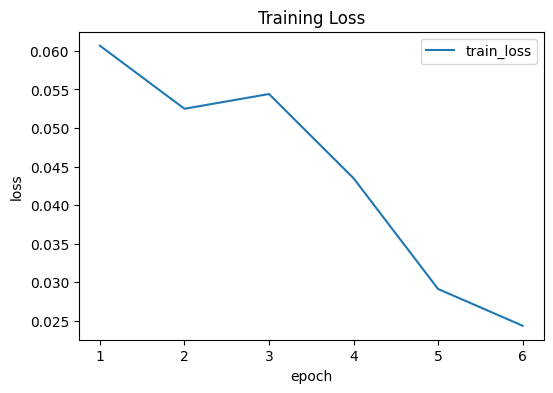

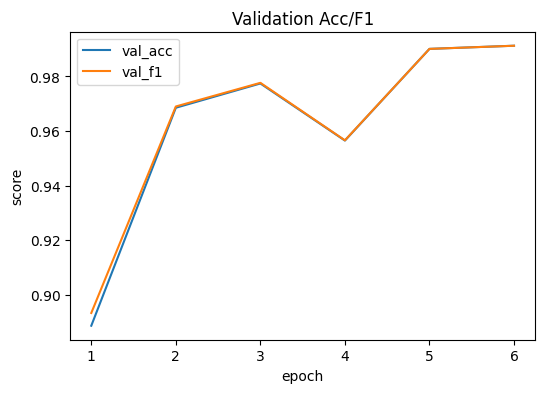

In [ ]:
# PLOTS 
import matplotlib.pyplot as plt

epochs = [h["epoch"] for h in history]
train_losses = [h["train_loss"] for h in history]
val_accs = [h["accuracy"] for h in history]
val_f1s = [h["f1"] for h in history]

plt.figure(figsize=(6,4))
plt.plot(epochs, train_losses, label="train_loss")
plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("Training Loss"); plt.legend(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs, val_accs, label="val_acc")
plt.plot(epochs, val_f1s, label="val_f1")
plt.xlabel("epoch"); plt.ylabel("score"); plt.title("Validation Acc/F1"); plt.legend(); plt.show()


**QUICK INFERENCE (load ckpt + compare_images)**

In [ ]:
# QUICK INFERENCE
@torch.no_grad()
def load_model_for_infer(ckpt_path, device):
    state = torch.load(ckpt_path, map_location=device)
    model = SiameseNet(state["backbone"]).to(device)
    model.load_state_dict(state["model"]); model.eval()
    return model, float(state["threshold"]), int(state.get("size", 224))

@torch.no_grad()
def compare_images(model, threshold, img_path1, img_path2, size, device):
    tf = T.Compose([
        T.Lambda(lambda im: binarize_and_crop(im)),
        T.Resize((size, size)),
        T.ToTensor(),
        T.Normalize(mean=[0.5]*3, std=[0.5]*3),
    ])
    x1 = tf(Image.open(img_path1)).unsqueeze(0).to(device)
    x2 = tf(Image.open(img_path2)).unsqueeze(0).to(device)
    dist, _, _ = model(x1, x2)
    dist = float(dist.item())
    return {"distance": dist, "threshold": float(threshold), "pred": ("Authentic" if dist < threshold else "Forged")}

model_inf, th_inf, sz_inf = load_model_for_infer(ckpt_path, DEVICE)
rootp = Path(ROOT_PATH)
p_org = next((rootp/"full_org").rglob("*.png"), None) or next((rootp/"ful_org").rglob("*.png"), None)
p_frg = next((rootp/"full_forg").rglob("*.png"), None)
if p_org and p_frg:
    print("Demo (org vs forg):", compare_images(model_inf, th_inf, p_org, p_frg, sz_inf, DEVICE))
else:
    print("Put sample images in full_org/ and full_forg/ to run the demo.")


[VisionBackbone] mambaout_tiny -> out_dim=2304
Demo (org vs forg): {'distance': 1.8991279602050781, 'threshold': 0.5926401615142822, 'pred': 'Forged'}


**SANITY CHECK**

In [ ]:
# === SANITY CHECK (optional) ===
print("Classes defined:", 'SiameseNet' in globals(), 'ContrastiveLoss' in globals())
print("BACKBONE =", BACKBONE)


Classes defined: True True
BACKBONE = mambaout_tiny


**SHOW TWO IMAGES + PREDICTION**

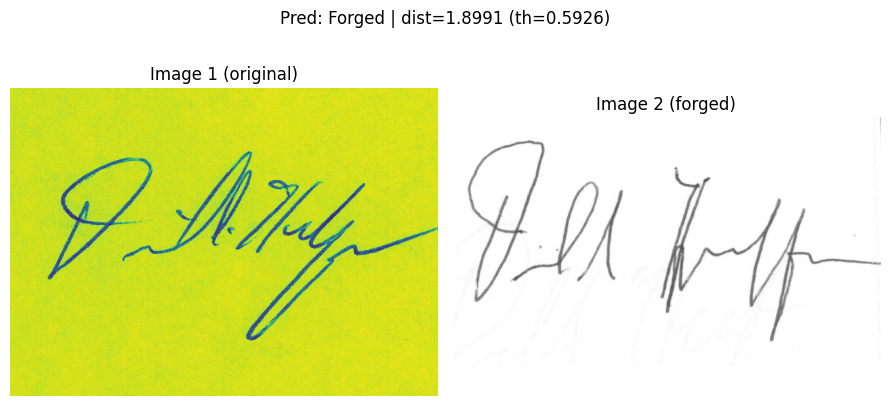

{'distance': 1.8991279602050781, 'threshold': 0.5926401615142822, 'pred': 'Forged'}


In [ ]:
# SHOW TWO IMAGES + PREDICTION
from pathlib import Path
import matplotlib.pyplot as plt

def show_pair_and_pred(img1_path: str, img2_path: str, label1="Image 1 (original)", label2="Image 2 (forged)"):
    global model_inf, th_inf, sz_inf
    if 'model_inf' not in globals():
        model_inf, th_inf, sz_inf = load_model_for_infer(ckpt_path, DEVICE)

    res = compare_images(model_inf, th_inf, img1_path, img2_path, sz_inf, DEVICE)

    fig, axes = plt.subplots(1, 2, figsize=(9, 4.5))
    axes[0].imshow(Image.open(img1_path)); axes[0].axis('off'); axes[0].set_title(label1)
    axes[1].imshow(Image.open(img2_path)); axes[1].axis('off'); axes[1].set_title(label2)
    fig.suptitle(f"Pred: {res['pred']} | dist={res['distance']:.4f} (th={res['threshold']:.4f})")
    plt.tight_layout(); plt.show()
    print(res)

# Demo (first png in full_org & full_forg)
rootp = Path(ROOT_PATH)
p_org = next((rootp/'full_org').rglob('*.png'), None) or next((rootp/'ful_org').rglob('*.png'), None)
p_frg = next((rootp/'full_forg').rglob('*.png'), None)
if p_org and p_frg:
    show_pair_and_pred(str(p_org), str(p_frg), "Image 1 (original)", "Image 2 (forged)")
else:
    print("Put images under full_org/ and full_forg/, then call show_pair_and_pred(path1, path2).")


**SALIENCY (SmoothGrad) SIMPLE OVERLAY (keep)**

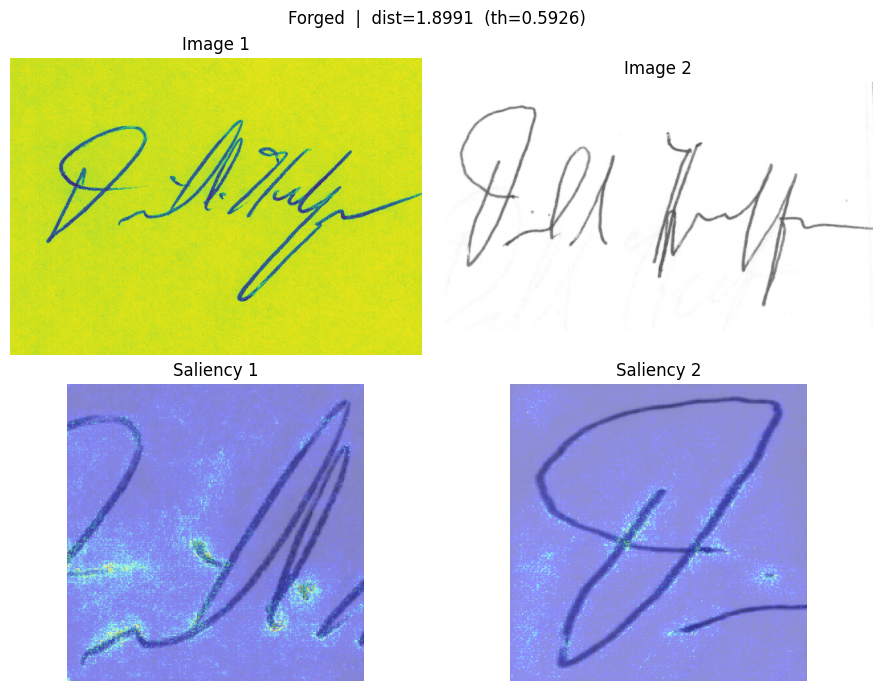

{'distance': 1.8991279602050781, 'threshold': 0.5926401615142822, 'pred': 'Forged'}


In [ ]:
# SALIENCY (SmoothGrad) FOR EACH INPUT, OVERLAY HEATMAPS 
import torch
import numpy as np
import matplotlib.pyplot as plt

_tf_no_norm = T.Compose([
    T.Lambda(lambda im: binarize_and_crop(im)),
    T.Resize((sz_inf if 'sz_inf' in globals() else SIZE, sz_inf if 'sz_inf' in globals() else SIZE)),
    T.ToTensor(),  # [0,1]
])
_tf_norm = T.Compose([
    T.Lambda(lambda im: binarize_and_crop(im)),
    T.Resize((sz_inf if 'sz_inf' in globals() else SIZE, sz_inf if 'sz_inf' in globals() else SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.5]*3, std=[0.5]*3),
])

def saliency_pair(model: torch.nn.Module, img1_path: str, img2_path: str,
                  smooth_samples: int = 8, noise_std: float = 0.08):
    model.eval()
    im1 = Image.open(img1_path); im2 = Image.open(img2_path)
    x1n = _tf_norm(im1).unsqueeze(0).to(DEVICE); x2n = _tf_norm(im2).unsqueeze(0).to(DEVICE)
    x1n.requires_grad_(True); x2n.requires_grad_(True)
    x1u = _tf_no_norm(im1); x2u = _tf_no_norm(im2)

    g1 = torch.zeros_like(x1n); g2 = torch.zeros_like(x2n)
    for _ in range(smooth_samples):
        n1 = torch.randn_like(x1n) * noise_std
        n2 = torch.randn_like(x2n) * noise_std
        x1p = (x1n + n1).clamp(-1, 1); x2p = (x2n + n2).clamp(-1, 1)
        if x1n.grad is not None: x1n.grad.zero_()
        if x2n.grad is not None: x2n.grad.zero_()
        model.zero_grad(set_to_none=True)
        d, _, _ = model(x1p, x2p)
        loss = -d.mean()  # pixels that reduce distance → "Authentic" evidence
        loss.backward()
        g1 += x1n.grad.detach().abs(); g2 += x2n.grad.detach().abs()

    g1 /= smooth_samples; g2 /= smooth_samples
    h1 = g1[0].max(dim=0).values; h2 = g2[0].max(dim=0).values
    h1 = (h1 - h1.min()) / (h1.max() - h1.min() + 1e-8)
    h2 = (h2 - h2.min()) / (h2.max() - h2.min() + 1e-8)

    img1_np = x1u.permute(1,2,0).cpu().numpy()
    img2_np = x2u.permute(1,2,0).cpu().numpy()
    return img1_np, img2_np, h1.cpu().numpy(), h2.cpu().numpy()

def show_pair_with_saliency(img1_path: str, img2_path: str,
                            smooth_samples: int = 8, noise_std: float = 0.08):
    global model_inf, th_inf, sz_inf
    if 'model_inf' not in globals():
        model_inf, th_inf, sz_inf = load_model_for_infer(ckpt_path, DEVICE)

    res = compare_images(model_inf, th_inf, img1_path, img2_path, sz_inf, DEVICE)
    img1_np, img2_np, h1_np, h2_np = saliency_pair(model_inf, img1_path, img2_path, smooth_samples, noise_std)

    fig, axes = plt.subplots(2, 2, figsize=(9, 7))
    axes[0,0].imshow(Image.open(img1_path)); axes[0,0].axis('off'); axes[0,0].set_title("Image 1")
    axes[0,1].imshow(Image.open(img2_path)); axes[0,1].axis('off'); axes[0,1].set_title("Image 2")
    axes[1,0].imshow(img1_np); axes[1,0].imshow(h1_np, cmap='jet', alpha=0.45); axes[1,0].axis('off'); axes[1,0].set_title("Saliency 1")
    axes[1,1].imshow(img2_np); axes[1,1].imshow(h2_np, cmap='jet', alpha=0.45); axes[1,1].axis('off'); axes[1,1].set_title("Saliency 2")
    fig.suptitle(f"{res['pred']}  |  dist={res['distance']:.4f}  (th={res['threshold']:.4f})")
    plt.tight_layout(); plt.show()
    print(res)

# Example call (first png it finds in full_org/ + full_forg/)
if 'p_org' in globals() and p_org and 'p_frg' in globals() and p_frg:
    show_pair_with_saliency(str(p_org), str(p_frg))
else:
    print("Provide two paths: show_pair_with_saliency(path1, path2)")


**CONFUSION MATRIX + DISTANCE HISTOGRAMS (VAL & TEST)**

Pairs -> train: 20976 | val: 6072 | test: 3312
[VisionBackbone] mambaout_tiny -> out_dim=2304
== VAL ==


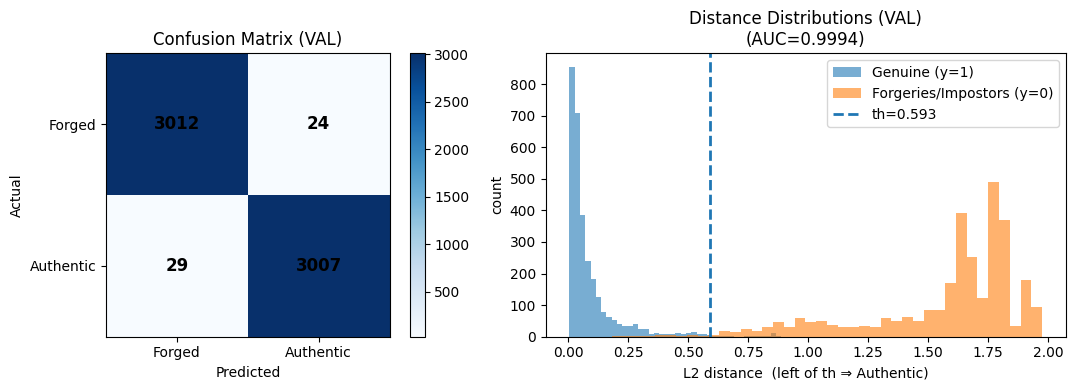

[(VAL)] acc=0.9913 | f1=0.9913 | FAR=0.0079 | FRR=0.0096 | AUC=0.9994 | th=0.5926
== TEST ==


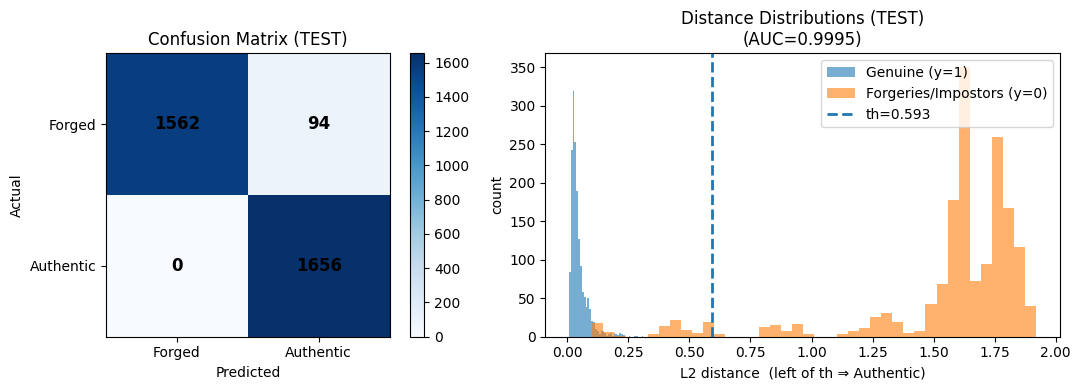

[(TEST)] acc=0.9716 | f1=0.9724 | FAR=0.0568 | FRR=0.0000 | AUC=0.9995 | th=0.5926


In [ ]:
# === CONFUSION MATRIX + DISTANCE HISTOGRAMS (VAL & TEST) ===
import numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

@torch.no_grad()
def _eval_and_visualize_confusion(model, loader, device, threshold, title_note="(set)"):
    dists, labels = collect_scores(model, loader, device)
    if dists.size == 0:
        print("No data.")
        return None

    preds = (dists < threshold).astype(int)
    y = labels.astype(int)

    acc = accuracy_score(y, preds)
    f1  = f1_score(y, preds)
    cm  = confusion_matrix(y, preds)
    far, frr = far_frr_at_threshold(dists, y, threshold)
    auc  = auc_from_dist(dists, y)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    ax = axes[0]
    im = ax.imshow(cm, cmap="Blues")
    ax.set_title(f"Confusion Matrix {title_note}")
    ax.set_xlabel("Predicted"); ax.set_ylabel("Actual")
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels(["Forged", "Authentic"])
    ax.set_yticklabels(["Forged", "Authentic"])
    for i in range(2):
        for j in range(2):
            ax.text(j, i, str(cm[i, j]), ha="center", va="center",
                    color="black", fontsize=12, fontweight="bold")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    ax2 = axes[1]
    ax2.hist(dists[y==1], bins=40, alpha=0.60, label="Genuine (y=1)")
    ax2.hist(dists[y==0], bins=40, alpha=0.60, label="Forgeries/Impostors (y=0)")
    ax2.axvline(threshold, linestyle="--", linewidth=2, label=f"th={threshold:.3f}")
    ax2.set_title(f"Distance Distributions {title_note}\n(AUC={auc:.4f})")
    ax2.set_xlabel("L2 distance  (left of th ⇒ Authentic)")
    ax2.set_ylabel("count"); ax2.legend()
    plt.tight_layout(); plt.show()

    print(f"[{title_note}] acc={acc:.4f} | f1={f1:.4f} | FAR={far:.4f} | FRR={frr:.4f} | AUC={auc:.4f} | th={threshold:.4f}")
    return {"accuracy":acc, "f1":f1, "far":far, "frr":frr, "auc":auc, "threshold":float(threshold), "cm":cm}

# Rebuild loaders to visualize on same splits
_, val_loader_vis, test_loader_vis = make_loaders(
    ROOT, SIZE, BATCH, SEED, CAP_TOTAL_PAIRS, WRITER_DISJOINT_SPLIT
)

# Load best model/threshold
model_vis, th_vis, _ = load_model_for_infer(ckpt_path, DEVICE)

print("== VAL ==")
val_vis = _eval_and_visualize_confusion(model_vis, val_loader_vis, DEVICE, th_vis, title_note="(VAL)")
print("== TEST ==")
test_vis = _eval_and_visualize_confusion(model_vis, test_loader_vis, DEVICE, th_vis, title_note="(TEST)")
